# Physical activity classification

## Imports

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

import tensorflow as tf
from tensorflow.keras import layers, models
import zipfile
import requests, zipfile, io


In [ ]:
from utils import create_windows

## Load data

Data source: https://archive.ics.uci.edu/dataset/231/pamap2%2Bphysical%2Bactivity%2Bmonitoring.

In [9]:
url = "https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip"

In [10]:
out_dir = Path("pamap2_raw")
out_dir.mkdir(exist_ok=True)

In [12]:
response = requests.get(url, timeout=60)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(out_dir)

print("Done!")

Done!


In [14]:
real_dir = Path("pamap2_raw/dataset/PAMAP2_Dataset")

In [15]:
inner_zip = Path("pamap2_raw/PAMAP2_Dataset.zip")
extract_dir = Path("pamap2_raw/dataset")

extract_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(inner_zip, "r") as z:
    z.extractall(extract_dir)

list(extract_dir.iterdir())


[PosixPath('pamap2_raw/dataset/PAMAP2_Dataset')]

In [16]:
file_101 = real_dir / "Protocol" / "subject101.dat"

df = pd.read_csv(
    file_101,
    sep=r"\s+",
    header=None,
    low_memory=False
)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [17]:
protocol_dir = real_dir / "Protocol"
protocol_files = sorted(protocol_dir.glob("subject*.dat"))
protocol_files

[PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject101.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject102.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject103.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject104.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject105.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject106.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject107.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject108.dat'),
 PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject109.dat')]

In [18]:
base_cols = ["timestamp", "activity_id", "heart_rate"]

imu_cols = [
    "temp", "acc16_x", "acc16_y", "acc16_z",
    "acc6_x", "acc6_y", "acc6_z",
    "gyro_x", "gyro_y", "gyro_z",
    "mag_x", "mag_y", "mag_z",
    "orient_w", "orient_x", "orient_y", "orient_z"
]

columns = (
    base_cols +
    [f"imu1_{c}" for c in imu_cols] +
    [f"imu2_{c}" for c in imu_cols] +
    [f"imu3_{c}" for c in imu_cols]
)

len(columns)


54

In [30]:
dfs = []
for file in protocol_files:
    df_subj = pd.read_csv(
        file,
        sep=r"\s+",
        header=None,
        low_memory=False
    )
    df_subj.columns = columns

    subj_id = int(file.stem.replace("subject", ""))
    df_subj["subject"] = subj_id
    dfs.append(df_subj)

df = pd.concat(dfs, ignore_index=True)
df.head()


,timestamp,activity_id,heart_rate,imu1_temp,imu1_acc16_x,imu1_acc16_y,imu1_acc16_z,imu1_acc6_x,imu1_acc6_y,imu1_acc6_z,...,imu3_gyro_y,imu3_gyro_z,imu3_mag_x,imu3_mag_y,imu3_mag_z,imu3_orient_w,imu3_orient_x,imu3_orient_y,imu3_orient_z,subject
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


Each sample in the dataset contains 54 sensor features, including timestamp, activity label, heart rate, and measurements from three Inertial Measurement Units (IMUs) placed on the hand, chest, and ankle. Each IMU contributes accelerometer, gyroscope, magnetometer, temperature, and orientation readings.

## EDA

In [31]:
activity_map = {
    0: "other",
    1: "lying",
    2: "sitting",
    3: "standing",
    4: "walking",
    5: "running",
    6: "cycling",
    7: "Nordic walking",
    9: "ascending stairs",
    10: "descending stairs",
    11: "vacuum cleaning",
    12: "ironing",
    13: "rope jumping",
}

df["activity"] = df["activity_id"].map(activity_map)
df["activity"].value_counts()


,count
activity,
other,929661
walking,238761
lying,192523
standing,189931
Nordic walking,188107
sitting,185188
cycling,164600
ironing,117216
rope jumping,104944


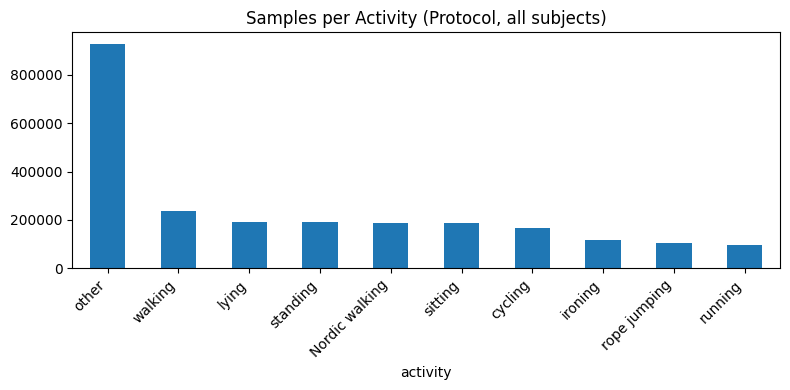

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
df["activity"].value_counts().plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.title("Samples per Activity (Protocol, all subjects)")
plt.tight_layout()
plt.show()


### Heart rate

In [33]:
df["heart_rate"].describe()


,heart_rate
count,262268.000000
mean,109.872508
std,25.870036
min,57.000000
25%,90.000000
50%,108.000000
75%,125.000000
max,202.000000


In [34]:
hr_by_act = df.groupby("activity")["heart_rate"].mean().sort_values()
hr_by_act


,heart_rate
activity,
lying,75.535682
sitting,80.012582
standing,88.557637
walking,112.789865
other,114.898315
Nordic walking,123.828701
cycling,124.879952
rope jumping,129.154175
ironing,129.523485


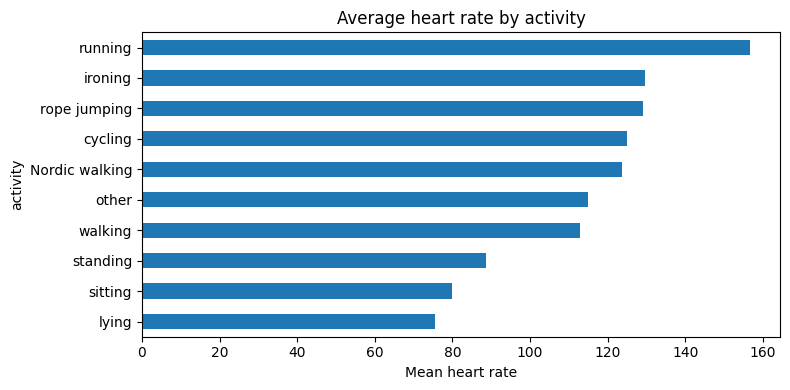

In [35]:
plt.figure(figsize=(8,4))
hr_by_act.plot(kind="barh")
plt.xlabel("Mean heart rate")
plt.title("Average heart rate by activity")
plt.tight_layout()
plt.show()


It is pretty obvious that for lying the heart rate is the smallest, while for running the biggest.

### Accelerometer magnitude

In [36]:
import numpy as np

df["imu1_acc_mag"] = np.sqrt(
    df["imu1_acc6_x"]**2 +
    df["imu1_acc6_y"]**2 +
    df["imu1_acc6_z"]**2
)

df["imu1_acc_mag"].describe()


,imu1_acc_mag
count,2.859392e+06
mean,1.071856e+01
std,4.518880e+00
min,8.006337e-02
25%,9.514498e+00
50%,9.868106e+00
75%,1.091744e+01
max,1.014832e+02


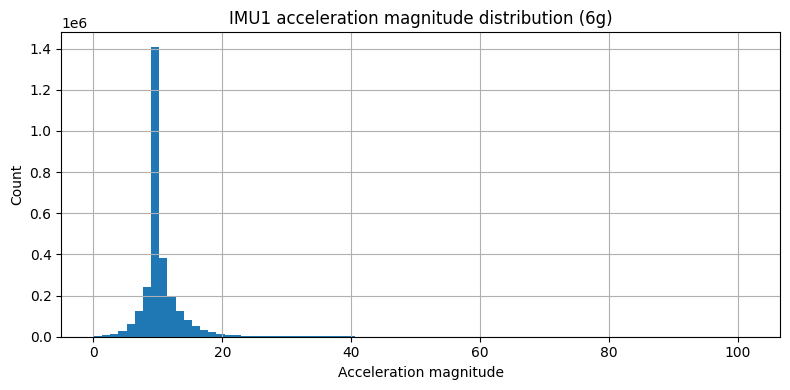

In [37]:
plt.figure(figsize=(8,4))
df["imu1_acc_mag"].hist(bins=80)
plt.title("IMU1 acceleration magnitude distribution (6g)")
plt.xlabel("Acceleration magnitude")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


The histogram shows the distribution of acceleration magnitude measured by the IMU placed on the hand (IMU1). Most values fall between 5–20 m/s², forming a sharp peak that corresponds to normal daily movements such as sitting, standing, or walking. A long but sparse tail extends toward higher magnitudes, reflecting short periods of more intense activities like running, stair climbing, or rope jumping.

<Figure size 1000x500 with 0 Axes>

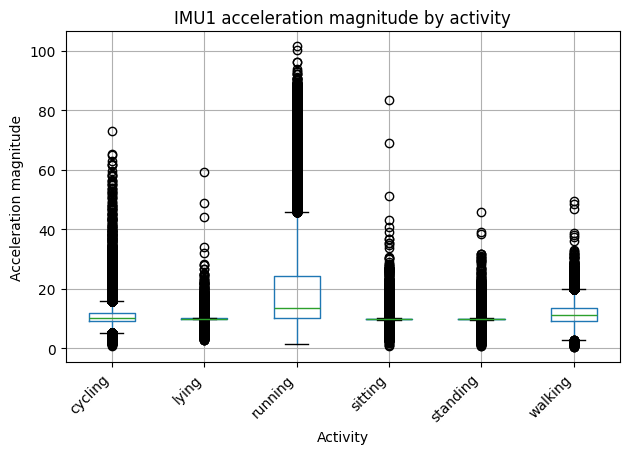

In [38]:
acts_to_show = ["lying", "sitting", "standing", "walking", "running", "cycling"]
subset = df[df["activity"].isin(acts_to_show)]

plt.figure(figsize=(10,5))
subset.boxplot(column="imu1_acc_mag", by="activity")
plt.title("IMU1 acceleration magnitude by activity")
plt.suptitle("")
plt.xlabel("Activity")
plt.ylabel("Acceleration magnitude")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Correlation between features

In [39]:
feat_sample = [
    "heart_rate",
    "imu1_acc6_x", "imu1_acc6_y", "imu1_acc6_z",
    "imu1_gyro_x", "imu1_gyro_y", "imu1_gyro_z",
    "imu1_acc_mag"
]

corr = df[feat_sample].corr()
corr


,heart_rate,imu1_acc6_x,imu1_acc6_y,imu1_acc6_z,imu1_gyro_x,imu1_gyro_y,imu1_gyro_z,imu1_acc_mag
heart_rate,1.000000,-0.202903,0.024732,-0.220252,0.007518,0.050337,-0.002146,0.213071
imu1_acc6_x,-0.202903,1.000000,-0.009103,0.209613,0.022020,-0.057555,0.023991,-0.422525
imu1_acc6_y,0.024732,-0.009103,1.000000,-0.081092,0.098868,-0.011712,0.039500,0.324518
imu1_acc6_z,-0.220252,0.209613,-0.081092,1.000000,-0.013309,-0.028184,-0.069326,-0.048828
imu1_gyro_x,0.007518,0.022020,0.098868,-0.013309,1.000000,-0.210373,-0.222958,0.041496
imu1_gyro_y,0.050337,-0.057555,-0.011712,-0.028184,-0.210373,1.000000,0.078362,0.048418
imu1_gyro_z,-0.002146,0.023991,0.039500,-0.069326,-0.222958,0.078362,1.000000,-0.034526
imu1_acc_mag,0.213071,-0.422525,0.324518,-0.048828,0.041496,0.048418,-0.034526,1.000000


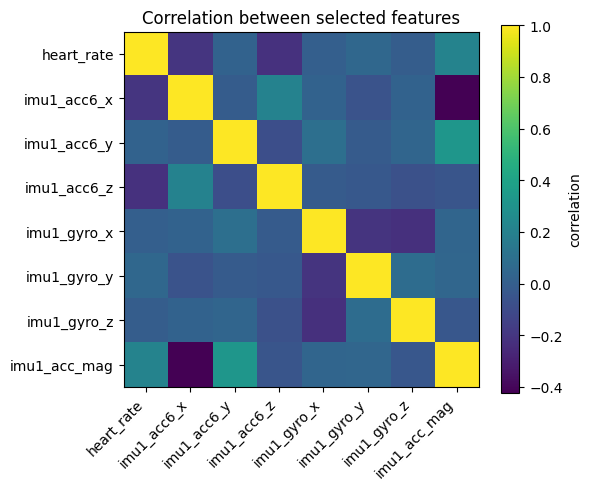

In [40]:
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(feat_sample)), feat_sample, rotation=45, ha="right")
plt.yticks(range(len(feat_sample)), feat_sample)
plt.colorbar(label="correlation")
plt.title("Correlation between selected features")
plt.tight_layout()
plt.show()


The correlation matrix shows that most IMU accelerometer and gyroscope features exhibit only weak to moderate correlations with one another.

### Activity classification model

In [43]:
dfs = []
for file in protocol_files:
    df_subj = pd.read_csv(
        file,
        sep=r"\s+",
        header=None,
        low_memory=False
    )
    df_subj.columns = columns
    subj_id = int(file.stem.replace("subject", ""))
    df_subj["subject"] = subj_id
    dfs.append(df_subj)

df = pd.concat(dfs, ignore_index=True)

In [44]:
df["activity_label"] = df["activity_id"].map(activity_map)

In [45]:
df = df[~df["activity_label"].isna()].copy()

Also, I'll drop "other" class:

In [46]:
df = df[df["activity_id"] != 0]

Filter for missing values:

In [47]:
sensor_cols = [c for c in df.columns if c not in ["timestamp", "activity_id", "activity_label", "subject"]]

df[sensor_cols] = (
    df.groupby("subject")[sensor_cols]
      .apply(lambda g: g.ffill().bfill())
      .reset_index(level=0, drop=True)
)

Create sliding windows and extract features:

In [48]:
WINDOW_SECONDS = 5
FS = 100
WINDOW_SIZE = WINDOW_SECONDS * FS
STEP_SIZE = 2 * FS

In [ ]:
feature_cols = [
    "heart_rate",
    "imu1_acc16_x", "imu1_acc16_y", "imu1_acc16_z",
    "imu1_acc6_x", "imu1_acc6_y", "imu1_acc6_z",
    "imu1_gyro_x", "imu1_gyro_y", "imu1_gyro_z",
    "imu2_acc16_x", "imu2_acc16_y", "imu2_acc16_z",
    "imu2_acc6_x", "imu2_acc6_y", "imu2_acc6_z",
    "imu2_gyro_x", "imu2_gyro_y", "imu2_gyro_z",
    "imu3_acc16_x", "imu3_acc16_y", "imu3_acc16_z",
    "imu3_acc6_x", "imu3_acc6_y", "imu3_acc6_z",
    "imu3_gyro_x", "imu3_gyro_y", "imu3_gyro_z",
]

In [49]:
feature_cols = [c for c in feature_cols if c in df.columns]

In [ ]:
X, y = create_windows(
    df,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE,
    feature_cols=feature_cols,
    label_col="activity_id",
)

Found protocol files: [PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject101.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject102.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject103.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject104.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject105.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject106.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject107.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject108.dat'), PosixPath('pamap2_raw/dataset/PAMAP2_Dataset/Protocol/subject109.dat')]
Shape after loading: (2872533, 55)
Shape after filtering activities: (1479469, 56)
Activities: activity_label
walking           238761
lying             192523
standing          189931
Nordic walking    188107
sitting           185188
cycling           164600
ironing           117216
rope jumping      104944
running            

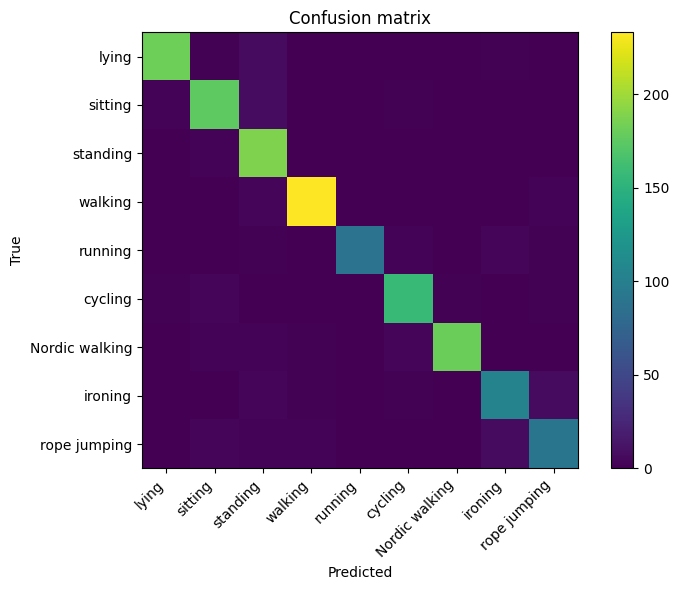

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

id_to_label = {k: v for k, v in activity_map.items() if k in classes}
target_names = [id_to_label[c] for c in sorted(classes)]

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred, labels=sorted(classes))
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, [id_to_label[c] for c in classes], rotation=45, ha="right")
plt.yticks(tick_marks, [id_to_label[c] for c in classes])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
